In [26]:
import os# change working directory
os.chdir('../')

import torch

import torch.nn.functional as F

from torch.utils.data import DataLoader
from dataloader.DDFF12.loader import DDFF12Loader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from model.modules.interpolator import Interpolator2D
from model.modules.DFV import DFFNet
from model.modules.GlobalScaleEstimator import LeastSquaresEstimator
from model.modules.depth_anything.dpt import DepthAnything

In [3]:
depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{:}14'.format('vits')).eval()
depth_anything.requires_grad_(False)
depth_anything.cuda()
depth_anything.eval()

xFormers not available
xFormers not available


DepthAnything(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
      

In [4]:
# construct DFV Model
DFF_model = DFFNet(clean=False,level=4, use_diff=1)
# self.DFF_model = nn.DataParallel(self.DFF_model)
DFF_model.cuda()
DFV_weights = '/home/ashka/PrecisionDepthFocus/DFF-DFV.tar'

if DFV_weights is not None:
    pretrained_dict = torch.load(DFV_weights)
    pretrained_dict['state_dict'] = {
    k.replace('module.', ''): v
    for k, v in pretrained_dict['state_dict'].items()
    if 'disp' not in k
    }
    # pretrained_dict['state_dict'] =  {k:v for k,v in pretrained_dict['state_dict'].items() if 'disp' not in k}
    DFF_model.load_state_dict(pretrained_dict['state_dict'],strict=False)
    print('Loaded  DFV model')
else:
    print('run with random init')
DFF_model.eval()
DFF_model.requires_grad_(False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded  DFV model


DFFNet(
  (feature_extraction): FeatExactor(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (b

In [14]:
def predic_depth_rel(batch):
    org_size = batch.shape
    
    # Assuming depth_anything returns a tensor, we can stack the results to form a batch again
    batch = F.interpolate(batch, size=(int(518), int(518)), mode='bicubic', align_corners=True)
    depth = depth_anything(batch).unsqueeze(1)
    
    # interploate to original size
    depth = F.interpolate(depth, size=(int(org_size[2]), int(org_size[3])), mode='bicubic', align_corners=True)

    return depth
        

In [46]:
# load data loader
data_loader = DataLoader(DDFF12Loader('/home/ashka/PrecisionDepthFocus/scripts/ddff_trainVal.h5'), batch_size=1, shuffle=False, num_workers=1)

disabled augmentation


In [47]:
# iterate over the dataset
for i, (aif, focal_stack, depth_gt, focus_dist, mask) in enumerate(data_loader):
    aif = aif.cuda()
    focal_stack = focal_stack.cuda()
    focus_dist = focus_dist.cuda()
    dff_depth, std, _ = DFF_model(focal_stack, focus_dist)
    rel_depth = predic_depth_rel(aif)
    break

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


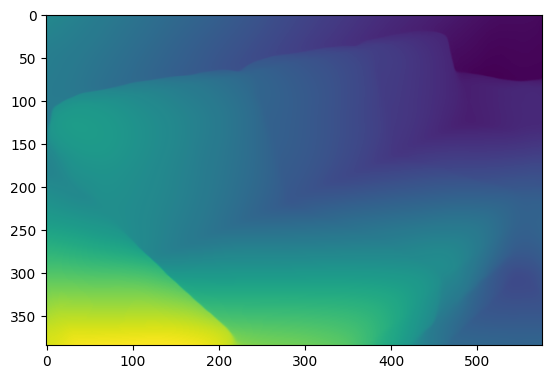

In [48]:

plt.imshow(rel_depth[0,0].cpu().detach().numpy())

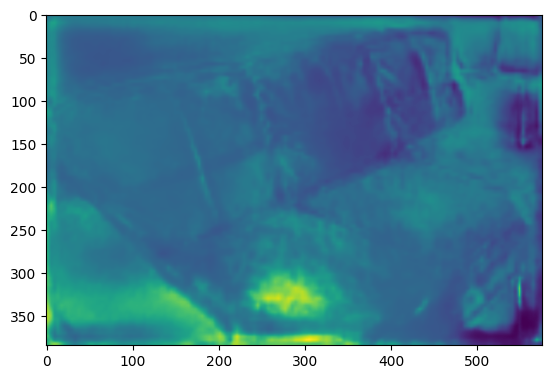

In [49]:
plt.imshow(dff_depth[0,0].cpu().detach().numpy())

In [52]:
valid_mask = torch.ones_like(mask, dtype=torch.bool)
valid_mask = valid_mask.cuda()

In [53]:
# global scale and shift alignment        
GlobalAlignment = LeastSquaresEstimator(
    estimate=rel_depth,
    target=dff_depth,
    valid= valid_mask
)


GlobalAlignment.compute_scale_and_shift()
GlobalAlignment.apply_scale_and_shift()
# GlobalAlignment.clamp_min_max(clamp_min=0.02, clamp_max=0.28)
intr_depth = GlobalAlignment.output.float()

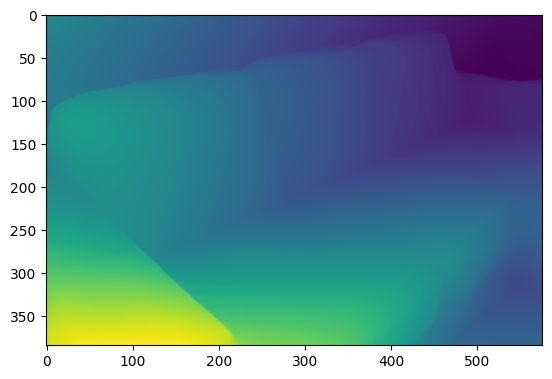

In [54]:
plt.imshow(intr_depth[0,0].cpu().detach().numpy())

In [57]:
intr_depth_np = intr_depth[0,0].cpu().detach().numpy()
dff_depth_np = dff_depth[0,0].cpu().detach().numpy()
valid_mask_np = valid_mask[0,0].cpu().detach().numpy()

In [58]:
ScaleMapInterpolator = Interpolator2D(
            pred_inv = intr_depth_np,
            sparse_depth_inv = dff_depth_np,
            valid = valid_mask_np,
        )
ScaleMapInterpolator.generate_interpolated_scale_map(
    interpolate_method='linear', 
    fill_corners=False
)


In [60]:
int_scales = ScaleMapInterpolator.interpolated_scale_map.astype(np.float32)
# int_scales = utils.normalize_unit_range(int_scales)

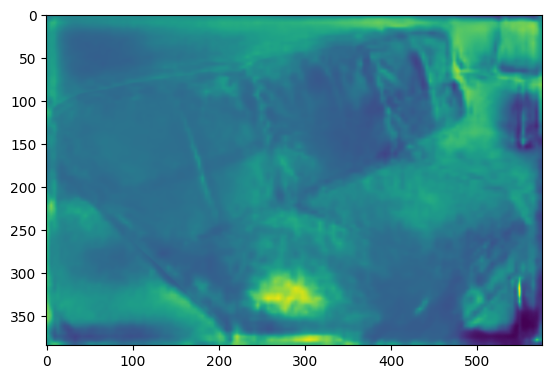

In [61]:
plt.imshow(int_scales)

In [62]:
int_scales

array([[0.99883187, 0.9972912 , 0.99852175, ..., 0.9898503 , 1.0242344 ,
        1.031916  ],
       [1.000916  , 1.0014718 , 0.99998814, ..., 0.9907382 , 1.0245863 ,
        1.0231205 ],
       [1.0024167 , 1.0022432 , 1.0035024 , ..., 0.9878873 , 1.0196486 ,
        1.0194339 ],
       ...,
       [1.0931916 , 1.0919752 , 1.1122816 , ..., 0.8124804 , 0.80519384,
        0.8043174 ],
       [1.0883207 , 1.0901905 , 1.1149083 , ..., 0.7732312 , 0.76810974,
        0.76605874],
       [1.1585531 , 1.1118983 , 1.113022  , ..., 0.77392524, 0.7686841 ,
        0.77777284]], dtype=float32)